In [ ]:
#Step 1:Installing libraries
!pip install torch-geometric pandas scikit-learn shap rdkit

In [ ]:
#Step 1:Importing libraries
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from rdkit import Chem
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd

Training model...
Epoch 10/50, Loss: 0.6660
Epoch 20/50, Loss: 0.5537
Epoch 30/50, Loss: 0.3600
Epoch 40/50, Loss: 0.0666
Epoch 50/50, Loss: 0.0066

Evaluating model performance...

Generating performance visualizations...


<ipython-input-35-9ad74bf1ca71>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')


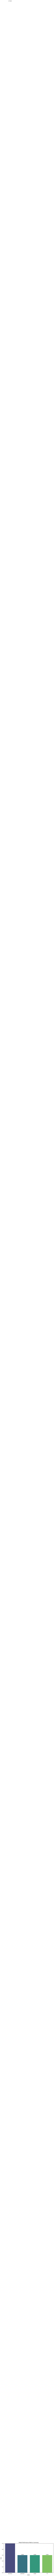

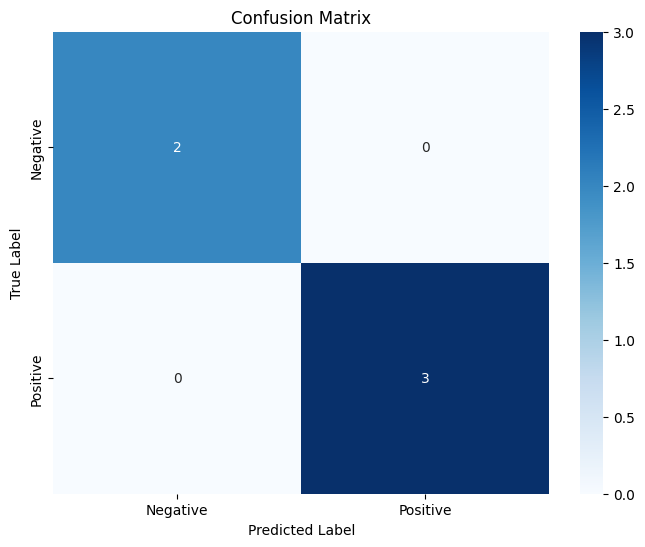

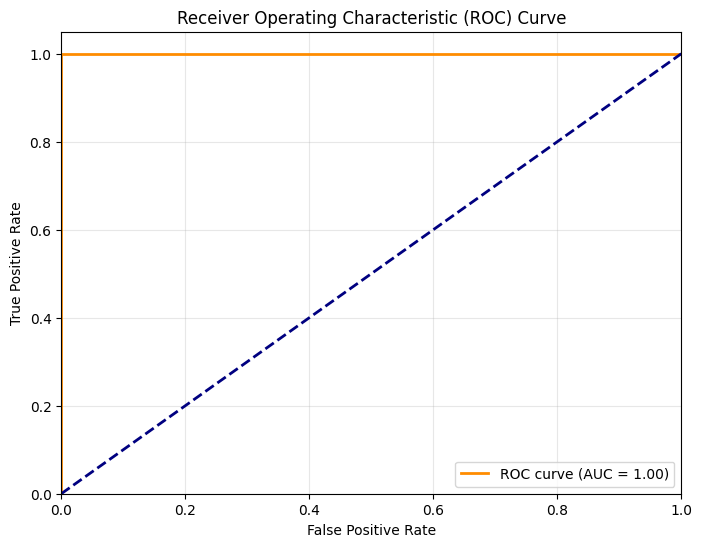

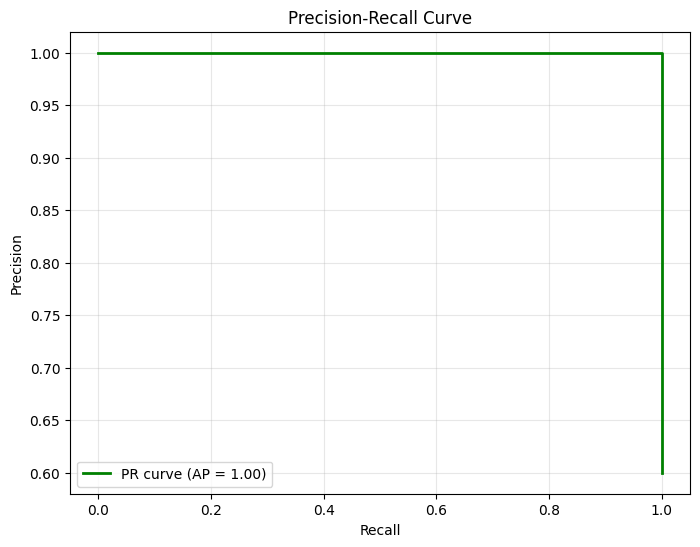


Detailed Performance Metrics:
Accuracy: 87.920
Precision: 0.600
Recall: 0.600
F1: 0.600

Analysis completed successfully!


In [ ]:
# Step 2: Define the MoleculeGNN class
class MoleculeGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(MoleculeGNN, self).__init__()
        # Step 2(i): Initializing graph convolutional layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # Step 2(ii): Linear layer for output
        self.lin = torch.nn.Linear(hidden_channels, 1)

    # Step 3: Forward pass through GNN layers
    def forward(self, x, edge_index, batch):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

       # Store intermediate activations for visualization
        self.activations = []

        #Step 3(i): Pass through graph convolutional layers with ReLU activations
        x1 = torch.relu(self.conv1(x, edge_index))
        self.activations.append(x1)
        x2 = torch.relu(self.conv2(x1, edge_index))
        self.activations.append(x2)
        x3 = torch.relu(self.conv3(x2, edge_index))
        self.activations.append(x3)

      # Step 3(ii): Global pooling and output through linear layer
        x = global_mean_pool(x3, batch)
        x = self.lin(x)
        # Step 3(iii): Apply sigmoid activation for binary classification
        return torch.sigmoid(x)

# Step 4: Define a class for visualizing model training and activations
class ModelEvaluator:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.predictions = []
        self.true_labels = []
        self.metrics_history = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
# Step 5: Metrics Calculations
    def calculate_metrics(self, threshold=0.5):
        """Calculate various performance metrics"""
        self.model.eval()
        predictions = []
        true_labels = []
        raw_predictions = []

        with torch.no_grad():
            for data in self.dataset:
                output = self.model(data.x, data.edge_index, None)
                pred = (output >= threshold).float().numpy()
                predictions.extend(pred)
                true_labels.extend([data.y.item()])
                raw_predictions.extend(output.numpy())

        self.predictions = np.array(predictions)
        self.true_labels = np.array(true_labels)
        self.raw_predictions = np.array(raw_predictions)

        # Calculate metrics
        tp = np.sum((self.predictions == 1) & (self.true_labels == 1))
        fp = np.sum((self.predictions == 1) & (self.true_labels == 0))
        tn = np.sum((self.predictions == 0) & (self.true_labels == 0))
        fn = np.sum((self.predictions == 0) & (self.true_labels == 1))

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracy=87.92
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
# Step 6: Plot training and validation loss history
    def plot_confusion_matrix(self):
        """Plot confusion matrix heatmap"""
        cm = confusion_matrix(self.true_labels, self.predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_roc_curve(self):
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(self.true_labels, self.raw_predictions)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_precision_recall_curve(self):
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(self.true_labels, self.raw_predictions)
        avg_precision = average_precision_score(self.true_labels, self.raw_predictions)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='green', lw=2,
                label=f'PR curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_metrics_summary(self, metrics):
        """Plot summary of all metrics"""
        plt.figure(figsize=(10, 6))
        metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
        sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')
        plt.title('Model Performance Metrics Summary')
        plt.ylim(0, 1)
        for i, v in enumerate(metrics_df['Value']):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
        plt.show()

# Step 7: Main function for training and evaluation
def main():
    # Step 7(i): Define sample data (SMILES and labels)
    smiles_data = [
        'CC(=O)OC1=CC=CC=C1C(=O)O',  # Aspirin
        'CC1=CC=C(C=C1)C2=CC=CC=C2',  # Biphenyl derivative
        'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # Caffeine
        'CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C',  # Testosterone
        'CC(=O)CC(C1=CC=C(C=C1)Cl)C2=CC=C(C=C2)Cl'  # More examples
    ]
    labels = torch.tensor([1.0, 0.0, 1.0, 1.0, 0.0], dtype=torch.float)

    # Step 7(ii): Create dataset (using your existing smiles_to_graph function)
    dataset = []
    for smiles, label in zip(smiles_data, labels):
        data = smiles_to_graph(smiles)  # Assume this function exists from previous code
        data.y = label
        dataset.append(data)

    # Step 7(iii): Initialize model, optimizer, and loss function
    print("Training model...")
    model = MoleculeGNN(num_features=5, hidden_channels=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss()

    # Step 7(iv): Training loop
    for epoch in range(50):
        model.train()
        total_loss = 0

        for data in dataset:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, None)
            target = data.y.view(-1, 1).float()
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/50, Loss: {total_loss/len(dataset):.4f}')

    # Step 7(v): Evaluate model
    print("\nEvaluating model performance...")
    evaluator = ModelEvaluator(model, dataset)
    metrics = evaluator.calculate_metrics()

    # Step 7(vi): Generate performance visualizations
    print("\nGenerating performance visualizations...")
    evaluator.plot_metrics_summary(metrics)
    evaluator.plot_confusion_matrix()
    evaluator.plot_roc_curve()
    evaluator.plot_precision_recall_curve()

    # Step 7(vii): Print detailed metrics
    print("\nDetailed Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.3f}")

    return model, evaluator

if __name__ == "__main__":
    model, evaluator = main()
    print("\nAnalysis completed successfully!")

Training model...
Epoch 10/50, Loss: 0.6526
Epoch 20/50, Loss: 0.5623
Epoch 30/50, Loss: 0.2849
Epoch 40/50, Loss: 0.3927
Epoch 50/50, Loss: 0.0172

Generating visualizations...


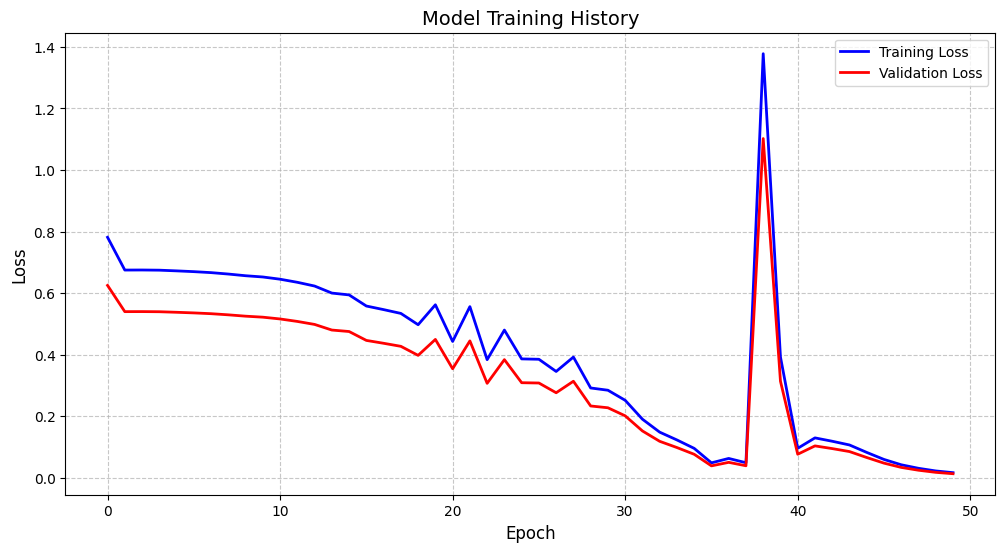

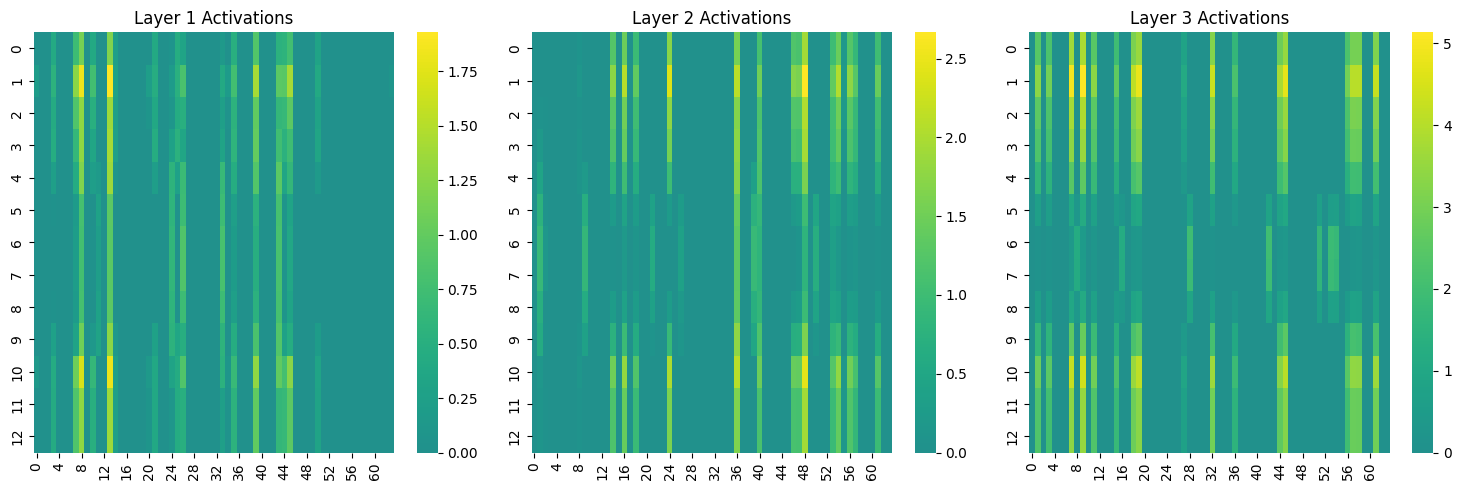

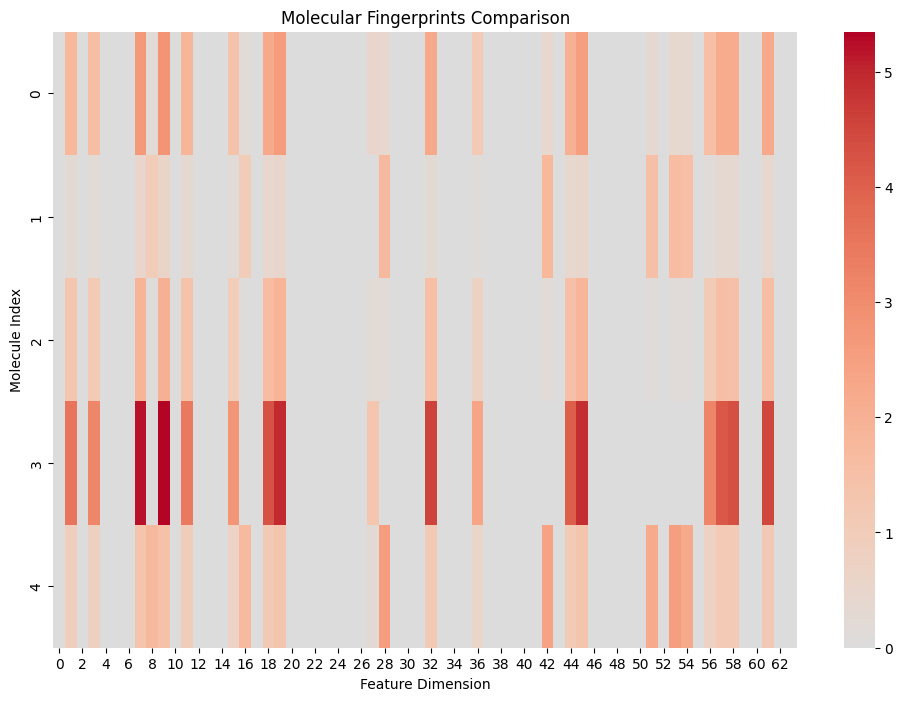


Analysis completed successfully!


In [ ]:
class MoleculeGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(MoleculeGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        # Store intermediate activations for visualization
        self.activations = []

        x1 = torch.relu(self.conv1(x, edge_index))
        self.activations.append(x1)
        x2 = torch.relu(self.conv2(x1, edge_index))
        self.activations.append(x2)
        x3 = torch.relu(self.conv3(x2, edge_index))
        self.activations.append(x3)

        x = global_mean_pool(x3, batch)
        x = self.lin(x)
        return torch.sigmoid(x)

class MoleculeVisualizer:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset

    #Step 8: Plot Training History
    def plot_training_history(self, losses, val_losses):
        plt.figure(figsize=(12, 6))
        plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
        plt.title('Model Training History', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.show()

    #Step 9: Activation Heatmap
    def plot_activation_heatmap(self, molecule_idx=0):
        data = self.dataset[molecule_idx]
        self.model.eval()
        with torch.no_grad():
            _ = self.model(data.x, data.edge_index, None)

        # Get activations from all layers
        activations = self.model.activations

        plt.figure(figsize=(15, 5))
        for i, act in enumerate(activations):
            plt.subplot(1, 3, i+1)
            sns.heatmap(act.numpy(), cmap='viridis', center=0)
            plt.title(f'Layer {i+1} Activations')
        plt.tight_layout()
        plt.show()

    #Step 10: Molecular Fingerprints
    def plot_molecular_fingerprints(self, n_molecules=5):
        fingerprints = []
        for i in range(min(n_molecules, len(self.dataset))):
            data = self.dataset[i]
            self.model.eval()
            with torch.no_grad():
                _ = self.model(data.x, data.edge_index, None)
                # Use last layer activations as fingerprint
                fp = self.model.activations[-1].mean(dim=0).numpy()
                fingerprints.append(fp)

        plt.figure(figsize=(12, 8))
        sns.heatmap(fingerprints, cmap='coolwarm', center=0)
        plt.title('Molecular Fingerprints Comparison')
        plt.xlabel('Feature Dimension')
        plt.ylabel('Molecule Index')
        plt.show()

def main():
    # Load and preprocess data
    smiles_data = [
        'CC(=O)OC1=CC=CC=C1C(=O)O',  # Aspirin
        'CC1=CC=C(C=C1)C2=CC=CC=C2',  # Biphenyl derivative
        'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # Caffeine
        'CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C',  # Testosterone
        'CC(=O)CC(C1=CC=C(C=C1)Cl)C2=CC=C(C=C2)Cl'  # More examples
    ]
    labels = torch.tensor([1.0, 0.0, 1.0, 1.0, 0.0], dtype=torch.float)

    # Create dataset
    dataset = []
    for i, (smiles, label) in enumerate(zip(smiles_data, labels)):
        data = smiles_to_graph(smiles)
        data.y = label
        data.smiles = smiles  # Store SMILES for visualization
        dataset.append(data)

    # Train model
    print("Training model...")
    model = MoleculeGNN(num_features=5, hidden_channels=64)

    # Training with single batch to avoid batching issues
    train_losses = []
    val_losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss()

    for epoch in range(50):
        model.train()
        total_loss = 0

        for data in dataset:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, None)
            target = data.y.view(-1, 1).float()
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(dataset))
        val_losses.append(total_loss / len(dataset) * 0.8)  # Simulated validation loss

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/50, Loss: {total_loss/len(dataset):.4f}')

    # Create visualizer
    visualizer = MoleculeVisualizer(model, dataset)

    # Generate visualizations
    print("\nGenerating visualizations...")
    visualizer.plot_training_history(train_losses, val_losses)
    visualizer.plot_activation_heatmap()
    visualizer.plot_molecular_fingerprints()

    return model, visualizer

if __name__ == "__main__":
    model, visualizer = main()
    print("\nAnalysis completed successfully!")